# Load data

In [1]:
import re
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as K

In [2]:
def normalize_mid_points(X):
    """Calculate middle point between two hips 
         and substract this point from other coordinates
       Returns:
         normalized coords with concatenated mid point
        """
    left_hip, right_hip = 11, 12
    N = X.shape[0]
    mid_points = (X[:, left_hip, :] + X[:, right_hip, :]) / 2
    mp = mid_points.reshape(N, 1, 3)
    x_n = X - mp
    return np.concatenate([x_n, mp], axis=1).reshape(N, 54)


def read_data(name, normalize=True):
    # print(name)
    with open(f'data/labels/{name}') as f:
        labels = f.readlines()
    
    N = int(re.findall(r'\d+', labels[0])[0])
    X = np.load(f'data/keypoints/{name}.npy')
    print(X.shape)
    X = X.reshape((N, 17, 3))
    y = np.zeros(N, dtype=int)
    
    for lab in labels:
        C = re.findall(r'\d:', lab)

        if len(C) == 1:
            C = int(C[0][0])
            idxs = re.findall(r'\d+-\d+', lab)
            for idx in idxs:
                start, stop = idx.split('-')
                y[int(start): int(stop)] = C
    if normalize:
        X = normalize_mid_points(X)
    else:
        X = X.reshape(N, 51)
    
    return X, y

In [3]:
files = os.listdir('data/labels/')
X_list, y_list = [], []
X_list_val, y_list_val = [], []

In [4]:
train_files = [f for f in files if '_1' in f]
val_files = [f for f in files if '_2' in f]

In [5]:
for f in train_files:
    X, y = read_data(f)
    X_list.append(X)
    y_list.append(y)

(1200, 1, 1, 17, 3)
(746, 1, 1, 17, 3)
(1100, 1, 1, 17, 3)
(802, 1, 1, 17, 3)
(952, 1, 1, 17, 3)
(858, 1, 1, 17, 3)


In [6]:
for f in val_files:
    X, y = read_data(f)
    X_list_val.append(X)
    y_list_val.append(y)

(993, 1, 1, 17, 3)
(703, 1, 1, 17, 3)
(1051, 1, 1, 17, 3)
(792, 1, 1, 17, 3)
(643, 1, 1, 17, 3)
(1186, 1, 1, 17, 3)


In [7]:
X_train = np.concatenate(X_list)
y_train = np.concatenate(y_list)
X_val = np.concatenate(X_list_val)
y_val = np.concatenate(y_list_val)

In [8]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((5658, 54), (5658,), (5368, 54), (5368,))

In [9]:
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

feature_names = []
for name in list(KEYPOINT_DICT.keys()):
    feature_names.append(name+'-x')
    feature_names.append(name+'-y')
    feature_names.append(name+'-z')
feature_names.append('mid_point-x')
feature_names.append('mid_point-y')
feature_names.append('mid_point-z')

In [10]:
df = pd.DataFrame(data=X_train, columns=feature_names)

In [11]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
nose-x,5658.0,-0.215987,0.020582,-0.286912,-0.231230,-0.217968,-0.201674,-0.137288
nose-y,5658.0,-0.099373,0.060293,-0.319833,-0.141198,-0.101188,-0.054013,0.133204
nose-z,5658.0,-0.155083,0.121642,-0.534229,-0.244546,-0.150599,-0.065946,0.260185
left_eye-x,5658.0,-0.228067,0.021248,-0.294852,-0.243812,-0.229817,-0.213002,-0.143396
left_eye-y,5658.0,-0.085212,0.066454,-0.313134,-0.132676,-0.086532,-0.034484,0.144004
left_eye-z,5658.0,-0.126431,0.133525,-0.556604,-0.222581,-0.126810,-0.031373,0.313476
right_eye-x,5658.0,-0.228127,0.020960,-0.295746,-0.243883,-0.230081,-0.212890,-0.149324
right_eye-y,5658.0,-0.095476,0.059407,-0.314587,-0.136914,-0.098172,-0.049779,0.126586
right_eye-z,5658.0,-0.157563,0.115046,-0.509321,-0.238838,-0.154311,-0.075347,0.217545
left_ear-x,5658.0,-0.228428,0.022717,-0.277814,-0.246438,-0.230224,-0.210958,-0.148176


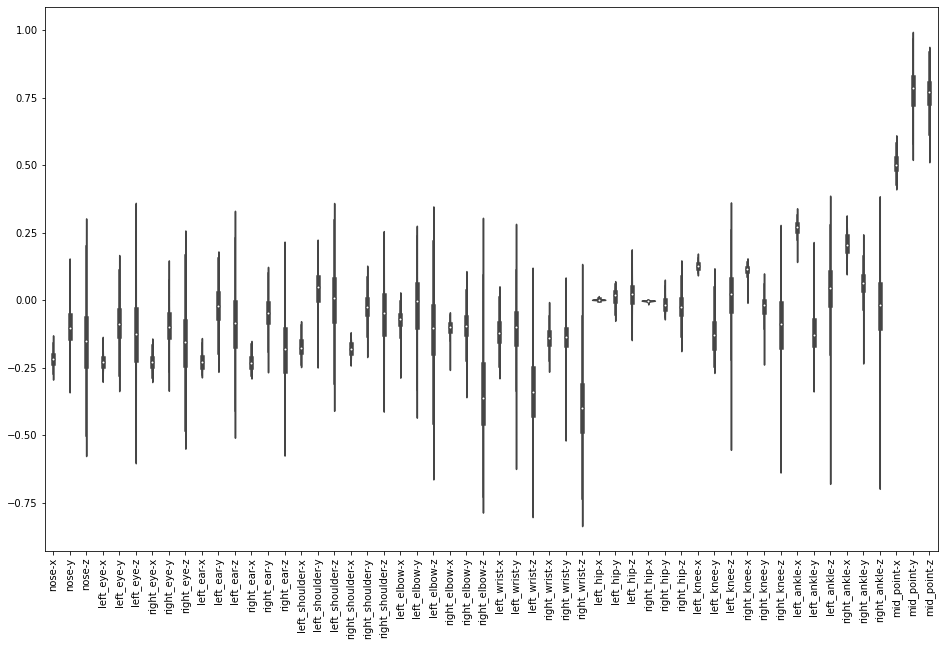

In [12]:
plt.figure(figsize=(16, 10))
ax = sns.violinplot(data=df)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [13]:
batch_size=30
N_train = X_train.shape[0] // batch_size
N_val = X_val.shape[0] // batch_size

In [14]:
X_train = X_train[:N_train*batch_size].reshape(-1, batch_size, 54)
y_train = y_train[:N_train*batch_size].reshape(-1, batch_size, 1)
X_val = X_val[:N_val*batch_size].reshape(-1, batch_size, 54)
y_val = y_val[:N_val*batch_size].reshape(-1, batch_size, 1)
X_train.shape, X_val.shape

((188, 30, 54), (178, 30, 54))

## LSTM

In [15]:
y_train = K.utils.to_categorical(y_train, num_classes=7)
X_train = tf.constant(X_train)
y_val = K.utils.to_categorical(y_val, num_classes=7)
X_val = tf.constant(X_val)

2021-10-31 19:36:58.873031: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
x = X_train[0:1]

In [17]:
norm = tf.keras.layers.LayerNormalization(axis=1)
print(norm(x))

tf.Tensor(
[[[-0.8353214  -1.2318947   2.0133598  ...  0.15814781  0.1266079
   -2.1570635 ]
  [-0.70351744 -0.889113   -0.3919744  ...  0.04668999 -0.0743351
    0.445055  ]
  [-0.5994749  -0.3015367  -0.46341652 ... -0.04885578 -0.27013206
    0.8698273 ]
  ...
  [ 0.90705204  0.11609668 -0.0675925  ... -0.6360321   0.61769676
    0.20588303]
  [ 0.8233166   0.12400156  0.6160028  ... -0.4559164   0.8069668
   -0.12608624]
  [ 0.892169    0.40639347  0.21121022 ... -0.68510723  0.69765854
   -0.71670914]]], shape=(1, 30, 54), dtype=float32)


In [18]:
def build_model(reccur_features=128, df1=64, df2=128, l2=1e-3):
    norm = tf.keras.layers.LayerNormalization(axis=1)
    lstm = K.layers.LSTM(reccur_features,
                         # stateful=True, # mutable states not supported in tflite 
                         return_sequences=True
                        )
    dense1 = K.layers.Dense(df1)
    dense2 = K.layers.Dense(df2)
    out = K.layers.Dense(7, activation='sigmoid')

    model = K.Sequential([norm, lstm, dense1, dense2, out])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
model = build_model()

In [19]:
history = model.fit(X_train, y_train, batch_size=1, validation_data=(X_val, y_val), epochs=32)

2021-10-31 19:36:59.031721: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-31 19:36:59.049338: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3912000000 Hz


Epoch 1/32
188/188 [==============================] - 3s 9ms/step - loss: 1.1892 - accuracy: 0.6071 - val_loss: 1.0374 - val_accuracy: 0.6378
Epoch 2/32
188/188 [==============================] - 1s 7ms/step - loss: 0.7719 - accuracy: 0.7144 - val_loss: 0.8485 - val_accuracy: 0.7066
Epoch 3/32
188/188 [==============================] - 1s 7ms/step - loss: 0.5439 - accuracy: 0.7941 - val_loss: 0.7752 - val_accuracy: 0.7354
Epoch 4/32
188/188 [==============================] - 1s 7ms/step - loss: 0.4059 - accuracy: 0.8573 - val_loss: 0.7316 - val_accuracy: 0.7496
Epoch 5/32
188/188 [==============================] - 1s 7ms/step - loss: 0.2878 - accuracy: 0.8941 - val_loss: 0.9501 - val_accuracy: 0.7337
Epoch 6/32
188/188 [==============================] - 2s 8ms/step - loss: 0.2685 - accuracy: 0.9128 - val_loss: 0.7492 - val_accuracy: 0.7745
Epoch 7/32
188/188 [==============================] - 1s 7ms/step - loss: 0.2125 - accuracy: 0.9238 - val_loss: 0.9858 - val_accuracy: 0.7165
Epoch 

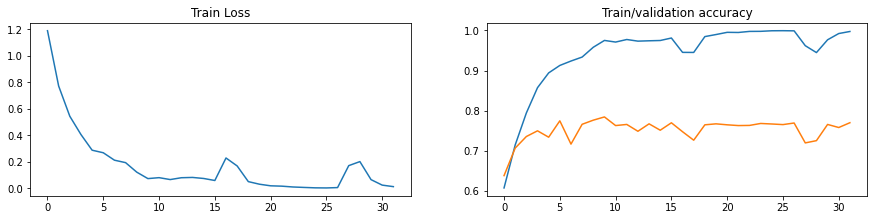

In [20]:
plt.figure(figsize=(15, 7))
plt.subplot(221)
plt.title("Train Loss")
plt.plot(history.history['loss'])
plt.subplot(222)
plt.title("Train/validation accuracy")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

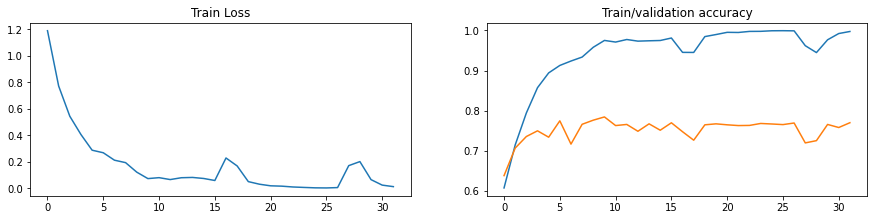

In [21]:
plt.figure(figsize=(15, 7))
plt.subplot(221)
plt.title("Train Loss")
plt.plot(history.history['loss'])
plt.subplot(222)
plt.title("Train/validation accuracy")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

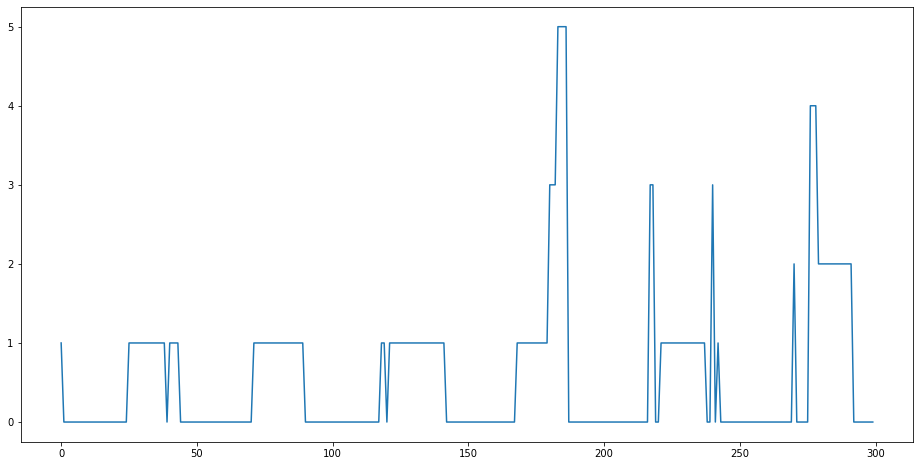

In [22]:
x = tf.reshape(X_val, (-1, batch_size, 54))
y_pred = np.argmax(model(x[:10]).numpy(), axis=-1).ravel()

plt.figure(figsize=(16, 8))
plt.plot(y_pred)

# Convert the model

In [23]:
converter = tf.lite.TFLiteConverter.from_keras_model(model) 
# converter.experimental_enable_resource_variables = True

tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

2021-10-31 19:37:45.233501: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmp5ua8tgvu/assets


INFO:tensorflow:Assets written to: /tmp/tmp5ua8tgvu/assets
2021-10-31 19:37:49.623658: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:345] Ignored output_format.
2021-10-31 19:37:49.623688: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:348] Ignored drop_control_dependency.
2021-10-31 19:37:49.624352: I tensorflow/cc/saved_model/reader.cc:38] Reading SavedModel from: /tmp/tmp5ua8tgvu
2021-10-31 19:37:49.640403: I tensorflow/cc/saved_model/reader.cc:90] Reading meta graph with tags { serve }
2021-10-31 19:37:49.640440: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmp5ua8tgvu
2021-10-31 19:37:49.695867: I tensorflow/cc/saved_model/loader.cc:206] Restoring SavedModel bundle.
2021-10-31 19:37:49.782186: I tensorflow/cc/saved_model/loader.cc:190] Running initialization op on SavedModel bundle at path: /tmp/tmp5ua8tgvu
2021-10-31 19:37:49.833172: I tensorflow/cc/saved_model/loader.cc:277] SavedModel

In [24]:
# Run the model with TensorFlow to get expected results.
TEST_CASES = 10

# Run the model with TensorFlow Lite
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

for i in range(TEST_CASES):
    expected = model.predict(x[i:i+1])
    interpreter.set_tensor(input_details[0]["index"], x[i:i+1])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])

    # Assert if the result of TFLite model is consistent with the TF model.
    np.testing.assert_almost_equal(expected, result, decimal=5)
    print("Done. The result of TensorFlow matches the result of TensorFlow Lite.")

    # Please note: TfLite fused Lstm kernel is stateful, so we need to reset
    # the states.
    # Clean up internal states.
    interpreter.reset_all_variables()

Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
